In [4]:
################################################################################################################################
#                                                      Project Notes                                                           #
################################################################################################################################

# Dataset from: https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc
# WAP: intensity values, they go from -104 to +100. +100 is used if WAP was not detected
# SpaceID: Internal ID number to ID space: office, corridor, or classroom (no specific ID for category identified)
# Relative Position: Position in respect to space: 1 is inside and 2 is "in front of the door"
# Models tested: SVM, Random Forest, Decision Trees, KNN


In [76]:
################################################################################################################################
#                                                      Load Models                                                             #
################################################################################################################################
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import scipy

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from numpy import mean
from numpy import std

In [6]:
################################################################################################################################
#                                                    Import Data                                                               #
################################################################################################################################

traindata = pd.read_csv('trainingData.csv')
valdata = pd.read_csv('validationData.csv')

In [7]:
################################################################################################################################
#                                                Evaluate Data/EDA                                                             #
################################################################################################################################

In [14]:
traindata.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [15]:
valdata.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [16]:
traindata.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [18]:
valdata.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,1111.000000,1111.0,1111.000000,1111.000000,1111.0,1111.0,1111.0,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1.111000e+03,1111.000000,1111.000000,1111.0,1111.0,1111.0,1111.000000,1.111000e+03
mean,98.627363,100.0,99.665167,99.665167,100.0,100.0,100.0,94.297030,90.655266,98.811881,...,99.843384,-7529.197448,4.864902e+06,1.571557,0.758776,0.0,0.0,0.0,11.923492,1.380604e+09
std,16.127245,0.0,7.888265,7.888607,0.0,0.0,0.0,32.148809,39.886991,14.931667,...,5.220261,120.209336,7.027280e+01,1.001828,0.816139,0.0,0.0,0.0,6.556236,5.003222e+05
min,-94.000000,100.0,-87.000000,-88.000000,100.0,100.0,100.0,-99.000000,-96.000000,-98.000000,...,-74.000000,-7695.938755,4.864748e+06,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.379578e+09
25%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7637.423800,4.864843e+06,1.000000,0.000000,0.0,0.0,0.0,9.000000,1.380189e+09
50%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7560.376300,4.864915e+06,1.000000,1.000000,0.0,0.0,0.0,13.000000,1.380873e+09
75%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7420.539659,4.864967e+06,2.000000,1.000000,0.0,0.0,0.0,15.000000,1.380875e+09
max,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7299.786517,4.865017e+06,4.000000,2.000000,0.0,0.0,0.0,21.000000,1.381248e+09


In [21]:
# Evaluating data Notes:
# We wil mainly rely on the WAP feautures to predict the position, rather than predicting a coordiante, we will engineer
# a new feauture that can be used to calcualte building, floow, and spaceID we are in. WAPs run up to 100 and as low as
# -104. Space ID goes from 1 to 254, but we also learn that the validation dataset does not have any spaceID, therefore
# our val data will serve more as a dataset that we will predict without having ground truth

In [13]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


In [8]:
pd.isnull(traindata).values.any()
pd.isnull(valdata).values.any()

False

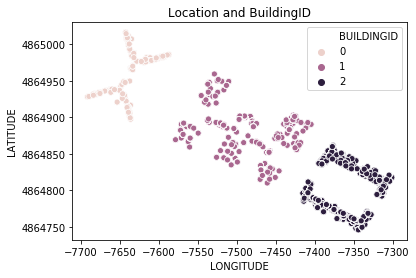

In [10]:
sb.scatterplot(x='LONGITUDE', y='LATITUDE', hue='BUILDINGID', data=traindata).set_title('Location and BuildingID')
plt.show()

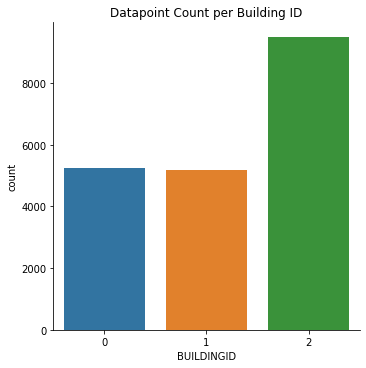

In [12]:
sb.catplot(x="BUILDINGID", kind= "count", data=traindata)
plt.title('Datapoint Count per Building ID')
plt.show()

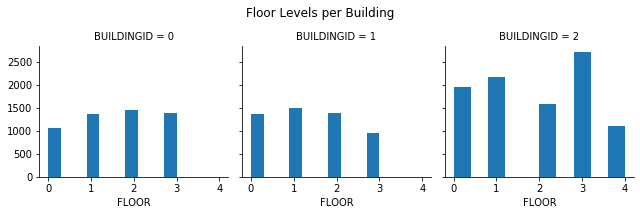

In [13]:
edaone = sb.FacetGrid(traindata, col='BUILDINGID')
edaone.map(plt.hist, 'FLOOR')
plt.subplots_adjust(top=0.8)
edaone.fig.suptitle('Floor Levels per Building')
plt.show()

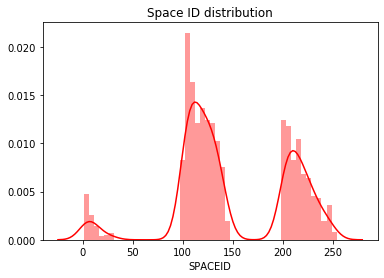

In [31]:
sb.distplot(traindata['SPACEID'], bins = 50, color='r')
plt.title('Space ID distribution')
plt.show()

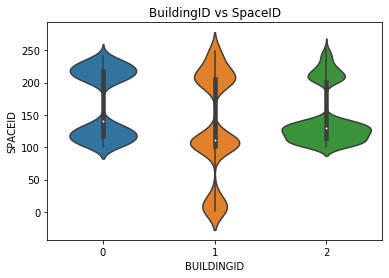

In [35]:
sb.violinplot(x= 'BUILDINGID', y='SPACEID', data=traindata)
plt.title('BuildingID vs SpaceID')
plt.show()

In [28]:
spaceidclasses = traindata.SPACEID.unique()
spaceidclasses.sort()
spaceidclasses

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  22,  25,  26,  27,  28,  29,  30, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 146, 147, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 253, 254], dtype=int64)

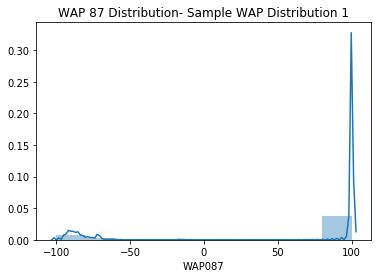

In [18]:
sb.distplot(traindata['WAP087'], bins= 10, kde_kws = {'bw' : 1})
plt.title('WAP 87 Distribution- Sample WAP Distribution 1')
plt.show()

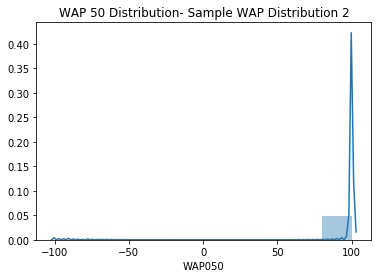

In [19]:
sb.distplot(traindata['WAP050'], bins= 10, kde_kws = {'bw' : 1})
plt.title('WAP 50 Distribution- Sample WAP Distribution 2')
plt.show()

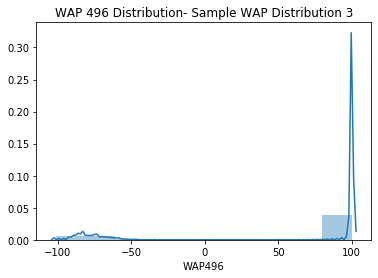

In [22]:
sb.distplot(traindata['WAP496'], bins= 10, kde_kws = {'bw' : 1})
plt.title('WAP 496 Distribution- Sample WAP Distribution 3')
plt.show()

In [36]:
# EDA Notes:
#Location and Building ID plot: this graph helps us better understand the layout of the buildings we are working with
#and also their location relative to their bumber ID

#Floor Levels per Building graph helps us understad that building 2 is the one that has the most floors, which might be 
#related to building 2 also having the most datapoint counts

#When it comes to SpaceID it looks like we don't have 250 values, we just have 123 and they are not continuos. We also 
#learn that some of the Space ID numbers can be found on more than one building, so they are not exclusive per building.

#As for the WAP we lear nthat the distribution in all WAPs is different, but one common thing is the prevelance of the
#class 100, which makes sense as ths class means that there is no signal.

In [37]:
################################################################################################################################
#                                                Preprocessing                                                                #
################################################################################################################################

In [38]:
#Converting Floor, BuildingID, and SpaceID into a single "LocationID" dependent feauture. Relative position is not super helpful
# and will just create double the classes, so won't be included

traindata['FLOOR']= traindata['FLOOR'].astype("str")
traindata['BUILDINGID']=traindata['BUILDINGID'].astype("str")
traindata['SPACEID']=traindata['SPACEID'].astype("str")
traindata['LOCATIONID'] = traindata['BUILDINGID'] + traindata['FLOOR'] + traindata['SPACEID']
traindata['LOCATIONID'] = traindata['LOCATIONID'].astype("category")
traindata

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,LOCATIONID
0,100,100,100,100,100,100,100,100,100,100,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,12106
1,100,100,100,100,100,100,100,100,100,100,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,12106
2,100,100,100,100,100,100,100,-97,100,100,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,12103
3,100,100,100,100,100,100,100,100,100,100,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,12102
4,100,100,100,100,100,100,100,100,100,100,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,00122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,...,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683,131
19933,100,100,100,100,100,100,100,100,100,100,...,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402,21140
19934,100,100,100,100,100,100,100,100,100,100,...,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921,1313
19935,100,100,100,100,100,100,100,100,100,100,...,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049,13113


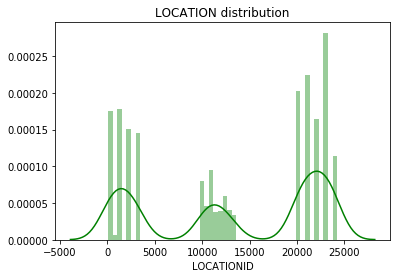

In [39]:
sb.distplot(traindata['LOCATIONID'], bins = 50, color='g')
plt.title('LOCATION distribution')
plt.show()

In [40]:
# LocationID will be the dependent variable, which will be gathered from three numbers: the Building ID, Floor ID, and SpaceID
# For instnace Building 1, Floor 2, in Space 3 will have a location ID of 123

In [41]:
#Removing Columns we are not going to use in the analysis
traindata= traindata.drop(['USERID','PHONEID','TIMESTAMP','LATITUDE','LONGITUDE',
                           'FLOOR','BUILDINGID','SPACEID','RELATIVEPOSITION'], axis=1)

valdata= valdata.drop(['USERID','PHONEID','TIMESTAMP','LATITUDE','LONGITUDE',
                           'FLOOR','BUILDINGID','SPACEID','RELATIVEPOSITION'], axis=1)

In [42]:
#WAP Re-Sorting-TRAIN DATA
traindata.iloc[:, 0:520] = np.where(traindata.iloc[:, 0:520] <= 0, 
                traindata.iloc[:, 0:520] + 105, 
                traindata.iloc[:, 0:520] - 100)

#WAP Re-Scaling -TRAIN DATA
traindata.iloc[:, 0:520] = traindata.iloc[:, 0:520]/105


#WAP Re-Sorting -VAL DATA
valdata.iloc[:, 0:520] = np.where(valdata.iloc[:, 0:520] <= 0, 
                valdata.iloc[:, 0:520] + 105, 
                valdata.iloc[:, 0:520] - 100)

#WAP Re-Scaling -VAL DATA
valdata.iloc[:, 0:520] = valdata.iloc[:, 0:520]/105


In [43]:
traindata.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LOCATIONID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12106
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12106
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07619,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12103
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12102
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00122


In [71]:
valdata.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
################################################################################################################################
#                                                Feature Selection                                                             #
################################################################################################################################

In [45]:
#Removing Zero Variace on WAP columns: If no variance on WAP, the feauture won't contrbute to out predicator
varfilter = VarianceThreshold(threshold=0)
varfilter.fit(traindata)
varcolumns = [column for column in traindata.columns
             if column not in traindata.columns[varfilter.get_support()]]

nvtraindata= traindata.drop(varcolumns, axis=1)

In [46]:
nvtraindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 466 entries, WAP001 to LOCATIONID
dtypes: category(1), float64(465)
memory usage: 70.8 MB


In [47]:
#Removing Highly Correlated WAP Columns
corrfeat = set()
corrmatrix = traindata.corr()

for i in range(len(corrmatrix.columns)):
    for j in range(i):
        if abs(corrmatrix.iloc[i,j])> 0.9:
            colname = corrmatrix.columns[i]
            corrfeat.add(colname)
            
corrtraindata = traindata.drop(corrfeat, axis=1)           


In [48]:
corrtraindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 414 entries, WAP001 to LOCATIONID
dtypes: category(1), float64(413)
memory usage: 62.9 MB


In [49]:
################################################################################################################################
#                                                TRAIN/TEST                                                                    #
################################################################################################################################

In [50]:
############################################  Train Test Models ################################################################
y = traindata.LOCATIONID
X = traindata.drop("LOCATIONID", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 134)

In [51]:
algos_Class = []
algos_Class.append(('Random Forest Classifier', RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_Class.append(('K Nearest Neighbors',KNeighborsClassifier()))
algos_Class.append(('SVM',SVC()))

results = []
names = []
for name, model in algos_Class:
        result = cross_val_score(model, X_train , y_train , cv=3, scoring='accuracy')
        names.append(name)
        results.append(result)
        

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [52]:
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier 0.829594765968715
Decision Tree Classifier 0.6214259928876817
K Nearest Neighbors 0.6953067289713982
SVM 0.5862415735568228


In [ ]:
# Random Forest was by far the best model, therefore we are ging to move forward with this model

In [61]:
############################### Train Test Different Data Column Combinations  ###############################################

In [56]:
modrf = RandomForestClassifier()

In [57]:
############################### No Correlated Feautures Dataset with Random Forests
y = corrtraindata.LOCATIONID
X = corrtraindata.drop("LOCATIONID", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 136)

resultcorr = cross_val_score(modrf, X_train , y_train , cv=3, scoring='accuracy')
resultcorr.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


0.8083834170223473

In [58]:
############################### No Variance Dataset with Random Forests
y = nvtraindata.LOCATIONID
X = nvtraindata.drop("LOCATIONID", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 135)

fit = RandomForestClassifier()
resultnv = cross_val_score(modrf, X_train , y_train , cv=3, scoring='accuracy')
resultnv.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


0.8303115655622896

In [ ]:
#Out of the box dataset and No variance have te best results so we wil look at those two more in detail

In [59]:
##################################      Comparing top two more in depth          ###############################################

In [62]:
#Zero Varaince Dataset- Balanaced Accuracy
resultnv = cross_val_score(modrf, X_train , y_train , cv=3, scoring='balanced_accuracy')
resultnv.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


0.8094899468776701

In [63]:
#Zero Varaince Dataset- F1 Score
resultnv = cross_val_score(modrf, X_train , y_train , cv=3, scoring='f1_weighted')
resultnv.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


0.8309157340483436

In [68]:
#OOB Dataset- Balanaced Accuracy
y = traindata.LOCATIONID
X = traindata.drop("LOCATIONID", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 134)

resultoob = cross_val_score(modrf, X_train , y_train , cv=3, scoring='balanced_accuracy')
resultoob.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.8054147562782741

In [69]:
#OOB Dataset- F1 Score
resultoob = cross_val_score(modrf, X_train , y_train , cv=3, scoring='f1_weighted')
resultoob.mean()

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


0.8274449140137276

In [70]:
# Results
dataresults = {'Accuracy':[0.829594765968715, 0.8303115655622896], 'Bal Accuracy':[0.8054147562782741,0.8094899468776701 ], 
               'F-1 Score' : [ 0.8274449140137276 ,0.8309157340483436] } 
trainresults = pd.DataFrame(dataresults, index =['OOB','ZV']) 
trainresults 

,Accuracy,Bal Accuracy,F-1 Score
OOB,0.829595,0.805415,0.827445
ZV,0.830312,0.809490,0.830916


In [67]:
# Zero Variance dataset with Random Forests gave us the best results in all our metrics

In [1]:
################################################################################################################################
#                                     Validation with Test Data                                                               #
################################################################################################################################

In [72]:
y = nvtraindata.LOCATIONID
X = nvtraindata.drop("LOCATIONID", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 135)

randomfor = RandomForestClassifier()
mod = randomfor.fit(X_train, y_train)
prediction = mod.predict(X_test)
print("Accuracy on Test Data: ", accuracy_score(y_test, prediction))

Accuracy on Test Data:  0.8488799732530926


In [73]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       00102       1.00      1.00      1.00         4
       00106       1.00      1.00      1.00         1
       00107       1.00      1.00      1.00         1
       00110       1.00      0.75      0.86         4
       00111       1.00      0.67      0.80         6
       00112       0.71      1.00      0.83         5
       00113       0.88      1.00      0.93         7
       00114       1.00      1.00      1.00         6
       00115       1.00      1.00      1.00         6
       00116       0.67      1.00      0.80         4
       00117       0.50      0.50      0.50         4
       00118       0.80      0.67      0.73         6
       00119       1.00      0.92      0.96        12
       00120       0.92      1.00      0.96        12
       00121       1.00      0.83      0.91         6
       00122       1.00      0.90      0.95        10
       00123       0.75      1.00      0.86         6
       00125       1.00    

C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marlos\Anaconda3\envs\Task1Env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


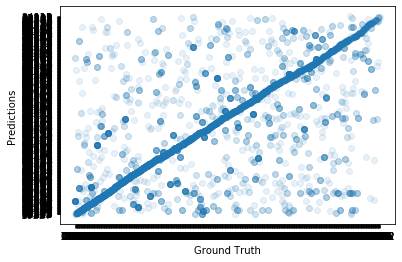

In [74]:
plt.scatter(y_test, prediction, alpha=0.1)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

In [79]:
################################################################################################################################
#                                   Predicing Values from Val Data                                                             #
################################################################################################################################

In [89]:
#Removing Zero Variace on WAP columns, Based on train results

nvvaldata= valdata.drop(varcolumns, axis=1)

In [90]:
nvvaldata.head()

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171429,0.171429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304762,0.314286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266667,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
predictionfinal = mod.predict(nvvaldata)

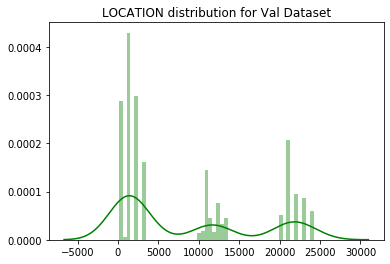

In [95]:
sb.distplot(predictionfinal, bins = 50, color='g')
plt.title('LOCATION distribution for Val Dataset')
plt.show()

In [141]:
################################################################################################################################
#                                               Further Validation                                                             #
################################################################################################################################

In [142]:
# Our validation dataset originally only had two Building ID and Floor ID. Therefore we can't directly know the ground truth
# since it is missing SPACEID. However, we can compare the first two numbers predicted by our model (which are Building ID and
# Floor ID, and we can see how accuractely our models predicted those two  values. It is not the ful prediction we can validate
# but at least it will give us an idea

In [159]:
predval = pd.DataFrame(predictionfinal) 
predval = pd.DataFrame(predictionfinal).astype("str")
predval['buildingfloor'] = predval[0].astype(str).str[:2]
predval['buildingfloor'] = predval['buildingfloor'].astype("category")

In [160]:
#BuildingFloor Column has the first two digits of our predictions, which stands for the Building and the Floor ID numbers
predval

,0,buildingfloor
0,20214,20
1,23140,23
2,24108,24
3,24110,24
4,02214,02
...,...,...
1106,23136,23
1107,23136,23
1108,00227,00
1109,00224,00


In [161]:
predvalground = pd.read_csv('validationData.csv')

In [162]:
#This dataframe will have the original Building + Foor IDs
predvalground ['FLOOR'] = predvalground ['FLOOR']. astype("str")
predvalground ['BUILDINGID']=predvalground ['BUILDINGID'].astype("str")
predvalground ['LOCATIONID'] = predvalground ['BUILDINGID'] + predvalground ['FLOOR']
predvalground ['LOCATIONID'] = predvalground ['LOCATIONID'].astype("category")
predvalground = predvalground  ['LOCATIONID']
predvalground = pd.DataFrame(predvalground)
predvalground

,LOCATIONID
0,11
1,24
2,24
3,24
4,02
...,...
1106,23
1107,23
1108,00
1109,00


In [164]:
print("Accuracy of Building and Floor: ", accuracy_score(predvalground ['LOCATIONID'], predval['buildingfloor']))

Accuracy of Building and Floor:  0.9036903690369037


In [ ]:
# This tells us that as far as it goes for BuildingID and Floor ID, our model predicts these two feautures with a 90% Accuracy
# Of course, our model also predicts the SPACE ID, however, the validation set does not have ground turth for SPACE ID. 
# Nvertheless, the accuracy of 90% on 2/3 feautures we are predicting gives us a high confidence in our model overall.